In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Stock Market Forecasting

Perusahaan investasi, hedge fund, dan bahkan individu telah menggunakan model keuangan untuk lebih memahami perilaku pasar dan melakukan investasi dan perdagangan yang menguntungkan. Banyak informasi tersedia dalam bentuk harga saham historis dan data kinerja perusahaan, yang cocok untuk diproses oleh algoritme pembelajaran mesin.

In [ ]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

We are going to do time series analysis and forecasting for stock market.

In [ ]:
stock = pd.read_csv('/content/drive/MyDrive/Tugas Time Series, Volatility, Monte Carlo/stock market/Amazon.csv')
stock

,Date,High,Low,Open,Close,Volume,Adj Close
0,2000-01-03,89.562500,79.046799,81.500000,89.375000,16117600,89.375000
1,2000-01-04,91.500000,81.750000,85.375000,81.937500,17487400,81.937500
2,2000-01-05,75.125000,68.000000,70.500000,69.750000,38457400,69.750000
3,2000-01-06,72.687500,64.000000,71.312500,65.562500,18752000,65.562500
4,2000-01-07,70.500000,66.187500,67.000000,69.562500,10505400,69.562500
...,...,...,...,...,...,...,...
4806,2019-02-11,1609.290039,1586.000000,1600.979980,1591.000000,3317300,1591.000000
4807,2019-02-12,1639.400024,1598.880005,1604.000000,1638.010010,4858600,1638.010010
4808,2019-02-13,1656.380005,1637.109985,1647.000000,1640.000000,3560300,1640.000000
4809,2019-02-14,1637.900024,1606.060059,1624.500000,1622.650024,4109600,1622.650024


## Data preprocessing

This step includes removing columns we do not need, check missing values, aggregate sales by date and so on.

In [ ]:
stock.isnull().sum()

Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [ ]:
stock = stock.groupby('Date')['Close'].sum().reset_index()

In [ ]:
stock.head()

,Date,Close
0,2000-01-03,89.3750
1,2000-01-04,81.9375
2,2000-01-05,69.7500
3,2000-01-06,65.5625
4,2000-01-07,69.5625


## Indexing with time series data

In [ ]:
stock = stock.set_index('Date')
stock.index

Index(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06', '2000-01-07',
       '2000-01-10', '2000-01-11', '2000-01-12', '2000-01-13', '2000-01-14',
       ...
       '2019-02-04', '2019-02-05', '2019-02-06', '2019-02-07', '2019-02-08',
       '2019-02-11', '2019-02-12', '2019-02-13', '2019-02-14', '2019-02-15'],
      dtype='object', name='Date', length=4811)

Data datetime kami saat ini bisa jadi rumit untuk dikerjakan, oleh karena itu, kami akan menggunakan rata-rata nilai penjualan harian untuk bulan itu, dan kami menggunakan awal setiap bulan sebagai stempel waktu.

In [ ]:
#y = stock['Close'].resample('M').mean()
stock.index = pd.to_datetime(stock.index)

monthly_mean = stock.Close.resample('M').mean()


## Visualizing Close time series data

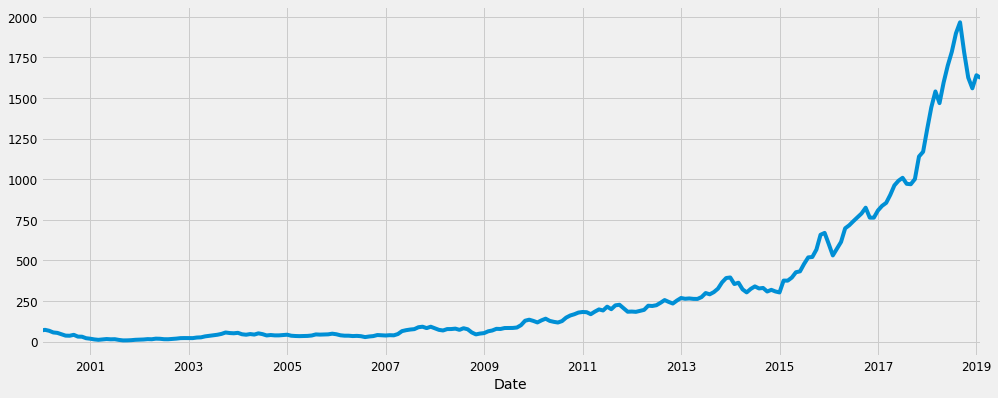

In [ ]:
monthly_mean.plot(figsize=(15, 6))
plt.show()

Beberapa pola yang dapat dibedakan muncul saat kita memplot data. Rangkaian waktu memiliki pola musiman

Kita juga dapat memvisualisasikan data kita menggunakan metode yang disebut dekomposisi deret waktu yang memungkinkan kita menguraikan deret waktu menjadi tiga komponen berbeda: tren, kemusiman, dan kebisingan.

### Time Series Decomposition Plot

Plot dekomposisi deret waktu memungkinkan kita mengamati istilah musiman, tren, dan kesalahan / sisa dari deret waktu. Ketiga komponen ini adalah bagian penting dari Exponential Smoothing models. Oleh karena itu, plot dekomposisi membantu dalam memutuskan jenis Exponential Smoothing models yang akan digunakan untuk perkiraan kami.

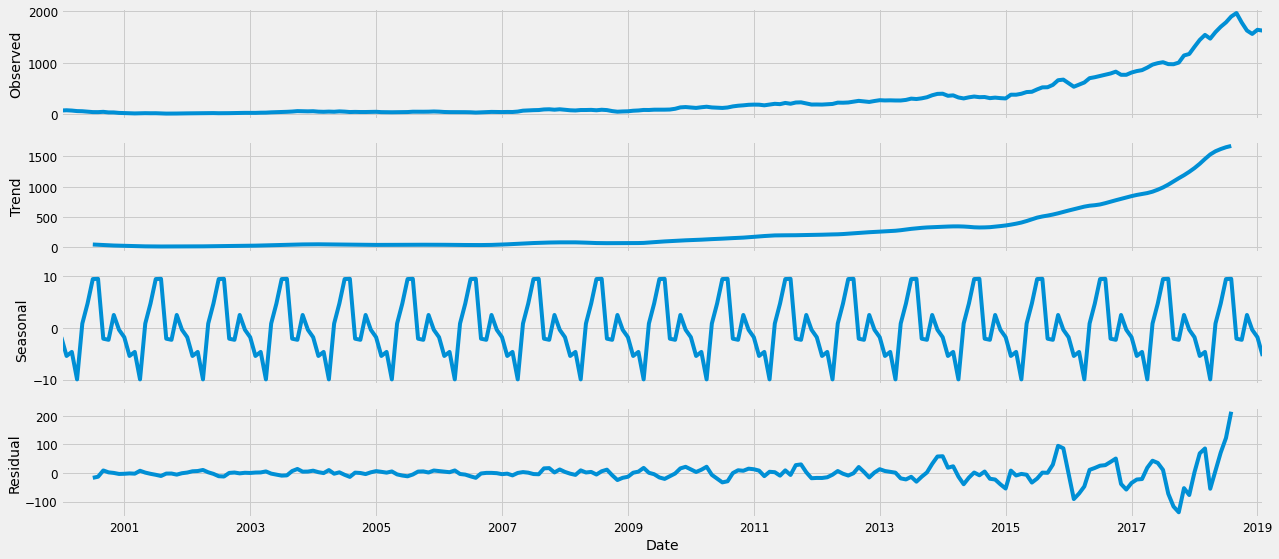

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(monthly_mean, model='additive')
fig = decomposition.plot()
plt.show()

Plot di atas dengan jelas menunjukkan bahwa harga Tutup tidak stabil, bersama dengan musimnya yang jelas.

### Tentukan Error, Trend and Seasonality

Model ETS memiliki tiga komponen utama: kesalahan, tren, dan musim. Masing-masing dapat diterapkan secara aditif, multiplikasi, atau tidak sama sekali. Kami akan menggunakan Plot Dekomposisi Seri Times di atas untuk menentukan properti aditif atau kesatuandari ketiga komponen.

1. Tren/Trend - Jika plot tren linier maka kami menerapkannya secara aditif (A). Jika garis tren tumbuh atau menyusut secara eksponensial, kami menerapkannya secara multiplikatif (M). Jika tidak ada trend yang jelas maka tidak ada komponen trend yang dimasukkan (N).

2. Musiman/Seasonality - Jika puncak dan lembah untuk musim konstan dari waktu ke waktu, kami menerapkannya secara aditif (A). Jika besar kecilnya fluktuasi musiman cenderung naik atau turun seiring dengan besarnya deret waktu, maka diterapkan secara multiplikatif (M). Jika tidak ada musim, itu tidak diterapkan (N).

3. Kesalahan/Error - Jika plot kesalahan memiliki varians konstan dari waktu ke waktu (puncak dan lembah berukuran hampir sama), kami menerapkannya secara aditif (A). Jika plot kesalahan berfluktuasi antara kesalahan besar dan kecil dari waktu ke waktu, kami menerapkannya secara multiplikatif (M).

<b> Untuk data, kami melihat plot tren trend and seasonality konstan dari waktu ke waktu, jadi kami akan menerapkan trend and seasonality secara aditif. Komponen kesalahan juga memiliki varian konstan, jadi kami akan menerapkannya juga secara aditif. </b>

<b> Kami akan menggunakan Exponential Smoothing, digunakan untuk perkiraan deret waktu. Metode Exponential Smoothing dapat didefinisikan dalam kerangka kerja ETS, di mana komponen dihitung menggunakan teknik Smoothing. </b>

## Time series forecasting with ARIMA

Kami akan menerapkan salah satu metode yang paling umum digunakan untuk peramalan deret waktu, yang dikenal sebagai ARIMA, yang merupakan singkatan dari Autoregressive Integrated Moving Average.

Pemilihan Parameter untuk Model Rangkaian Waktu ARIMA. Model ARIMA dilambangkan dengan notasi `ARIMA (p, d, q)`. Ketiga parameter ini memperhitungkan musim, tren, dan kebisingan dalam data: `

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
l_param = []
l_param_seasonal=[]
l_results_aic=[]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(monthly_mean,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            l_param.append(param)
            l_param_seasonal.append(param_seasonal)
            l_results_aic.append(results.aic)
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:3517.1844160246774
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:3170.756862178461
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2905.5162868130506
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2709.948755884161
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2634.9447198554626
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2586.6015517292185
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2636.5202271757134
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2517.962586394575
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:3209.5357836566336
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2890.2821160175818
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2633.047634098909
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2469.300772217539
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2438.763900678464
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2368.5095846004497
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:2441.5622388546094
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2325.112118816908
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2266.1614580597984
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2159.3375758657776

In [ ]:
minimum=l_results_aic[0]
for i in l_results_aic[1:]:
    if i < minimum: 
        minimum = i
i=l_results_aic.index(minimum)

In [ ]:
mod = sm.tsa.statespace.SARIMAX(monthly_mean,
                                order=l_param[i],
                                seasonal_order=l_param_seasonal[i],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3891      0.037     10.454      0.000       0.316       0.462
ar.S.L12      -0.4845      0.065     -7.430      0.000      -0.612      -0.357
ma.S.L12      -0.5767      0.062     -9.267      0.000      -0.699      -0.455
sigma2      1095.0987     45.264     24.194      0.000    1006.384    1183.814


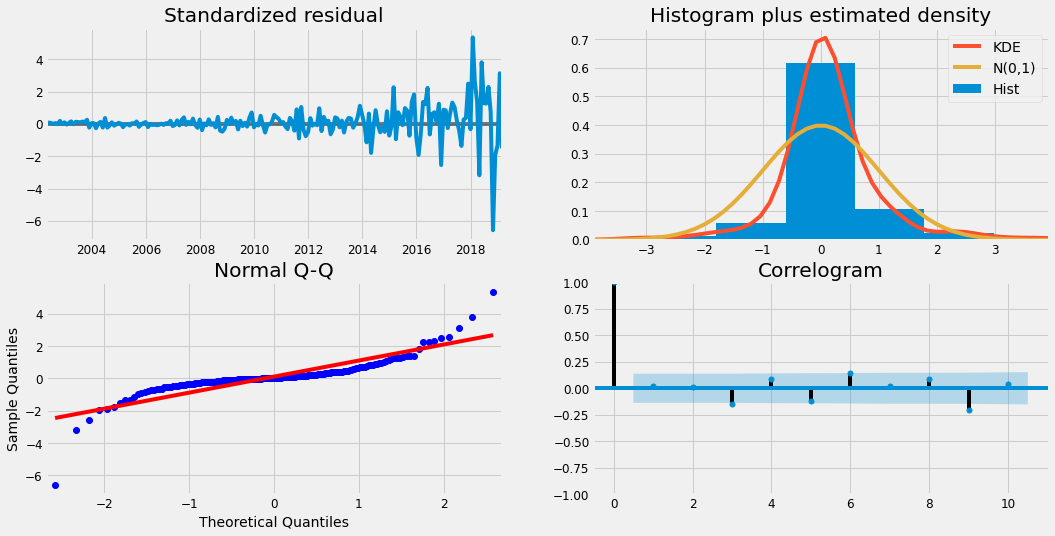

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

## Validating forecasts

Untuk membantu kami memahami keakuratan perkiraan, kami membandingkan prediksi mendekati harga penutupan nyata dari deret waktu, dan kami menetapkan perkiraan untuk dimulai pada `2017-12-31` hingga akhir data.

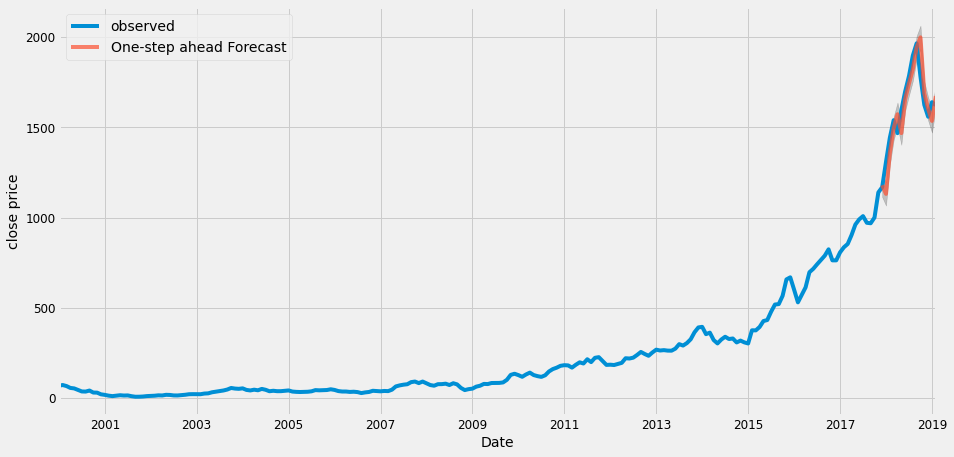

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2017-12-31'), dynamic=False)
pred_ci = pred.conf_int()

ax = monthly_mean['2000':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('close price')
plt.legend()

plt.show()

Plot garis menunjukkan nilai yang diamati dibandingkan dengan prediksi perkiraan bergulir. Secara keseluruhan, perkiraan kami selaras dengan nilai sebenarnya dengan sangat baik, menunjukkan tren peningkatan mulai dari awal tahun.

## Producing and visualizing forecasts

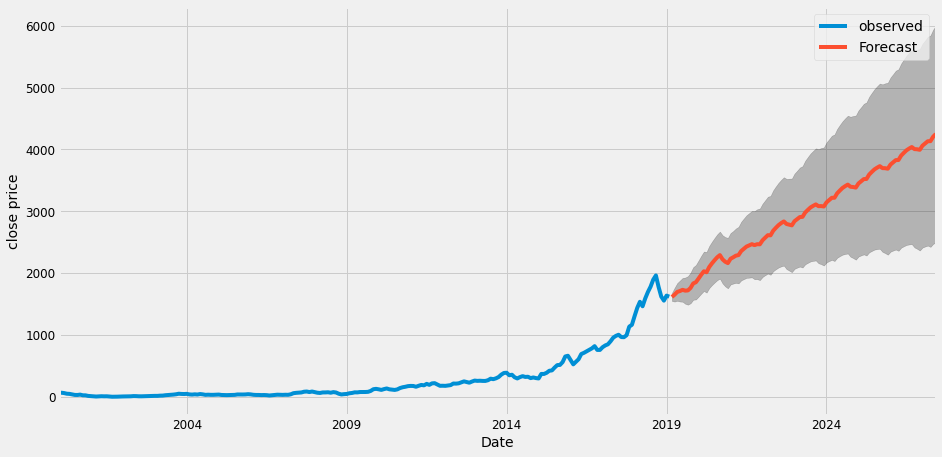

In [ ]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = monthly_mean.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('close price')

plt.legend()
plt.show()

Model kami dengan jelas menangkap tren harga penutupan. Saat meramalkan lebih jauh ke masa depan, wajar jika kita menjadi kurang percaya diri pada nilai-nilai kita. 

# Understanding GARCH Estimation

In [ ]:
!pip install arch command
from arch import arch_model

     |████████████████████████████████| 808kB 6.2MB/s 
  Created wheel for command: filename=Command-0.1.0-cp37-none-any.whl size=6406 sha256=15350e850d99712ecd8f600a959d0b931d8247c4869e8b0404302b0e6132474e
  Stored in directory: /root/.cache/pip/wheels/6b/61/e7/7e78f4d431de4a7d1f83af33f599d0bfe03e65fe3ff1ad73c5
Successfully built command


In [ ]:
stock = pd.read_csv('/content/drive/MyDrive/Tugas Time Series, Volatility, Monte Carlo/stock market/Amazon.csv')
stock

,Date,High,Low,Open,Close,Volume,Adj Close
0,2000-01-03,89.562500,79.046799,81.500000,89.375000,16117600,89.375000
1,2000-01-04,91.500000,81.750000,85.375000,81.937500,17487400,81.937500
2,2000-01-05,75.125000,68.000000,70.500000,69.750000,38457400,69.750000
3,2000-01-06,72.687500,64.000000,71.312500,65.562500,18752000,65.562500
4,2000-01-07,70.500000,66.187500,67.000000,69.562500,10505400,69.562500
...,...,...,...,...,...,...,...
4806,2019-02-11,1609.290039,1586.000000,1600.979980,1591.000000,3317300,1591.000000
4807,2019-02-12,1639.400024,1598.880005,1604.000000,1638.010010,4858600,1638.010010
4808,2019-02-13,1656.380005,1637.109985,1647.000000,1640.000000,3560300,1640.000000
4809,2019-02-14,1637.900024,1606.060059,1624.500000,1622.650024,4109600,1622.650024


##GARCH

In [ ]:
# Split the series to predict the last 3 months of 2017
temp_stock = stock.set_index('Date')
train_stock = temp_stock.loc[:'2017-09-30'].reset_index(drop=False)                         
test_stock = temp_stock.loc['2017-10-01':].reset_index(drop=False)

In [ ]:
returns = pd.DataFrame(np.log(train_stock['Open']).diff().dropna())
returns.rename(columns={'Open':'Log Return Rate'}, inplace=True)

In [ ]:
from statsmodels.tsa.stattools import adfuller
returns_array_like = [x for l in returns.values for x in l]
_, pvalue, *_ = adfuller(returns_array_like)
print ('pvalue :',pvalue)

pvalue : 4.280597274994772e-20


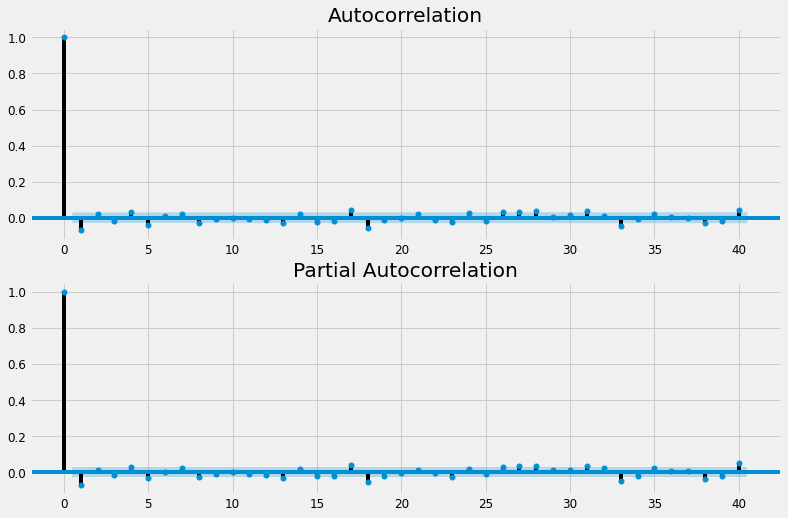

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(returns.values, lags=40, alpha=0.05, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(returns.values, lags=40, alpha=0.05, ax=ax2)

In [ ]:
import  statsmodels.tsa.stattools as sts
resid = sts.arma_order_select_ic(returns, max_ar=4, max_ma=4,ic=['aic','bic','hqic'], trend='nc', fit_kw=dict(method='css'))
print ('AIC-order :{}'.format(resid.aic_min_order))
print ('BIC-order :{}'.format(resid.bic_min_order))
print ('HQIC-order :{}'.format(resid.hqic_min_order))

AIC-order :(4, 4)
BIC-order :(2, 0)
HQIC-order :(4, 4)


In [ ]:
arma_mod01 = sm.tsa.ARMA(returns, (1, 0)).fit()
print (arma_mod01.summary())
print ('-------------------------------------')
print (arma_mod01.params)

                              ARMA Model Results                              
Dep. Variable:        Log Return Rate   No. Observations:                 4464
Model:                     ARMA(1, 0)   Log Likelihood                8784.355
Method:                       css-mle   S.D. of innovations              0.034
Date:                Wed, 28 Apr 2021   AIC                         -17562.710
Time:                        03:58:07   BIC                         -17543.498
Sample:                             0   HQIC                        -17555.938
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.0006      0.000      1.165      0.244      -0.000       0.001
ar.L1.Log Return Rate    -0.0691      0.015     -4.630      0.000      -0.098      -0.040
        

### Prediction results of the GARCH model

In [ ]:
from arch import arch_model
from arch.univariate import ZeroMean, GARCH, StudentsT, ConstantMean

In [ ]:
arch_mod = ConstantMean(returns)
arch_mod.volatility = GARCH(1,0,1)
arch_mod.distribution = StudentsT()
res=arch_mod.fit(update_freq=5, disp='off')
print (res.summary())
print (' ')
print ('The estimated parameters: ')
print ('----------------------------------------')
print (res.params)

                        Constant Mean - GARCH Model Results                         
Dep. Variable:              Log Return Rate   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -554002.
Distribution:      Standardized Student's t   AIC:                       1.10801e+06
Method:                  Maximum Likelihood   BIC:                       1.10805e+06
                                              No. Observations:                 4464
Date:                      Wed, Apr 28 2021   Df Residuals:                     4463
Time:                              04:06:05   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            39

/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


In [ ]:
mu = arma_mod01.params[0]
theta = arma_mod01.params[1]
omega = res.params[1]
alpha = res.params[2]
beta = res.params[3]
print(mu, theta, omega, alpha, beta)

0.000551732063256933 -0.06913794054774963 0.009824362247701132 0.0 0.00026004379085825156
